In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from IPython.display import display, HTML
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import make_scorer, f1_score, average_precision_score, plot_confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

sns.set(color_codes=True)
%matplotlib inline

seed = 1

In [2]:
red_wines = pd.read_csv('winequality-red.csv', sep=';')
red_wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
print('There are %d instances in the dataset' % len(red_wines))

There are 1599 instances in the dataset


In [4]:
red_wines.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [5]:
red_wines.isnull().any()

fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

There are no missing values in the dataset. 

In [6]:
pd.unique(red_wines.quality)

array([5, 6, 7, 4, 8, 3])

There are 6 unique wine quality values in the dataset. We plan to approach this as a calssification problem with 3 classes instead of seeing it as a regression problem.

Let's look at the distribution of the quality values as shown below. 

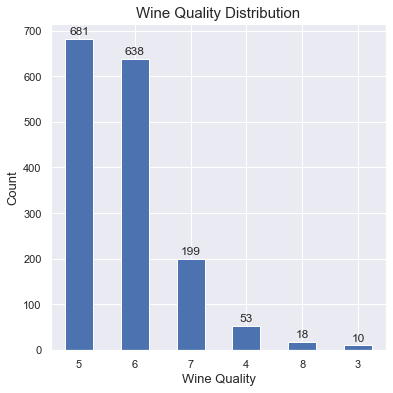

In [7]:
fig, ax = plt.subplots(figsize=(6,6))
red_wines.quality.value_counts().plot(kind='bar', ax=ax)
rects = ax.patches
for rect, label in zip(rects, red_wines.quality.value_counts().values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xlabel('Wine Quality', fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.set_title('Wine Quality Distribution', fontsize=15)
plt.show()

As can be seen above this is an imbalanced dataset. There are very few wines with low and high quality scores. 

Let's look at the quality distribution based on type of wines as shown below.

Let's divide this dataset into 3 groups based on quality:

* poor: quality between 0-4
* mediocre: quality between 5-6
* good: quality between 7-10

In [8]:
red_wines['quality'] = red_wines.quality.replace({0:'poor', 1:'poor', 2:'poor', 3:'poor', 4:'poor', 5:'mediocre', 
                                                  6:'mediocre', 7:'good', 8:'good', 9:'good', 10:'good'})

In [9]:
red_wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,mediocre
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,mediocre
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,mediocre
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,mediocre
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,mediocre


In [10]:
pd.value_counts(red_wines.quality)

mediocre    1319
good         217
poor          63
Name: quality, dtype: int64

This is a highly inbalanced dataset with most wines being mediocre. 

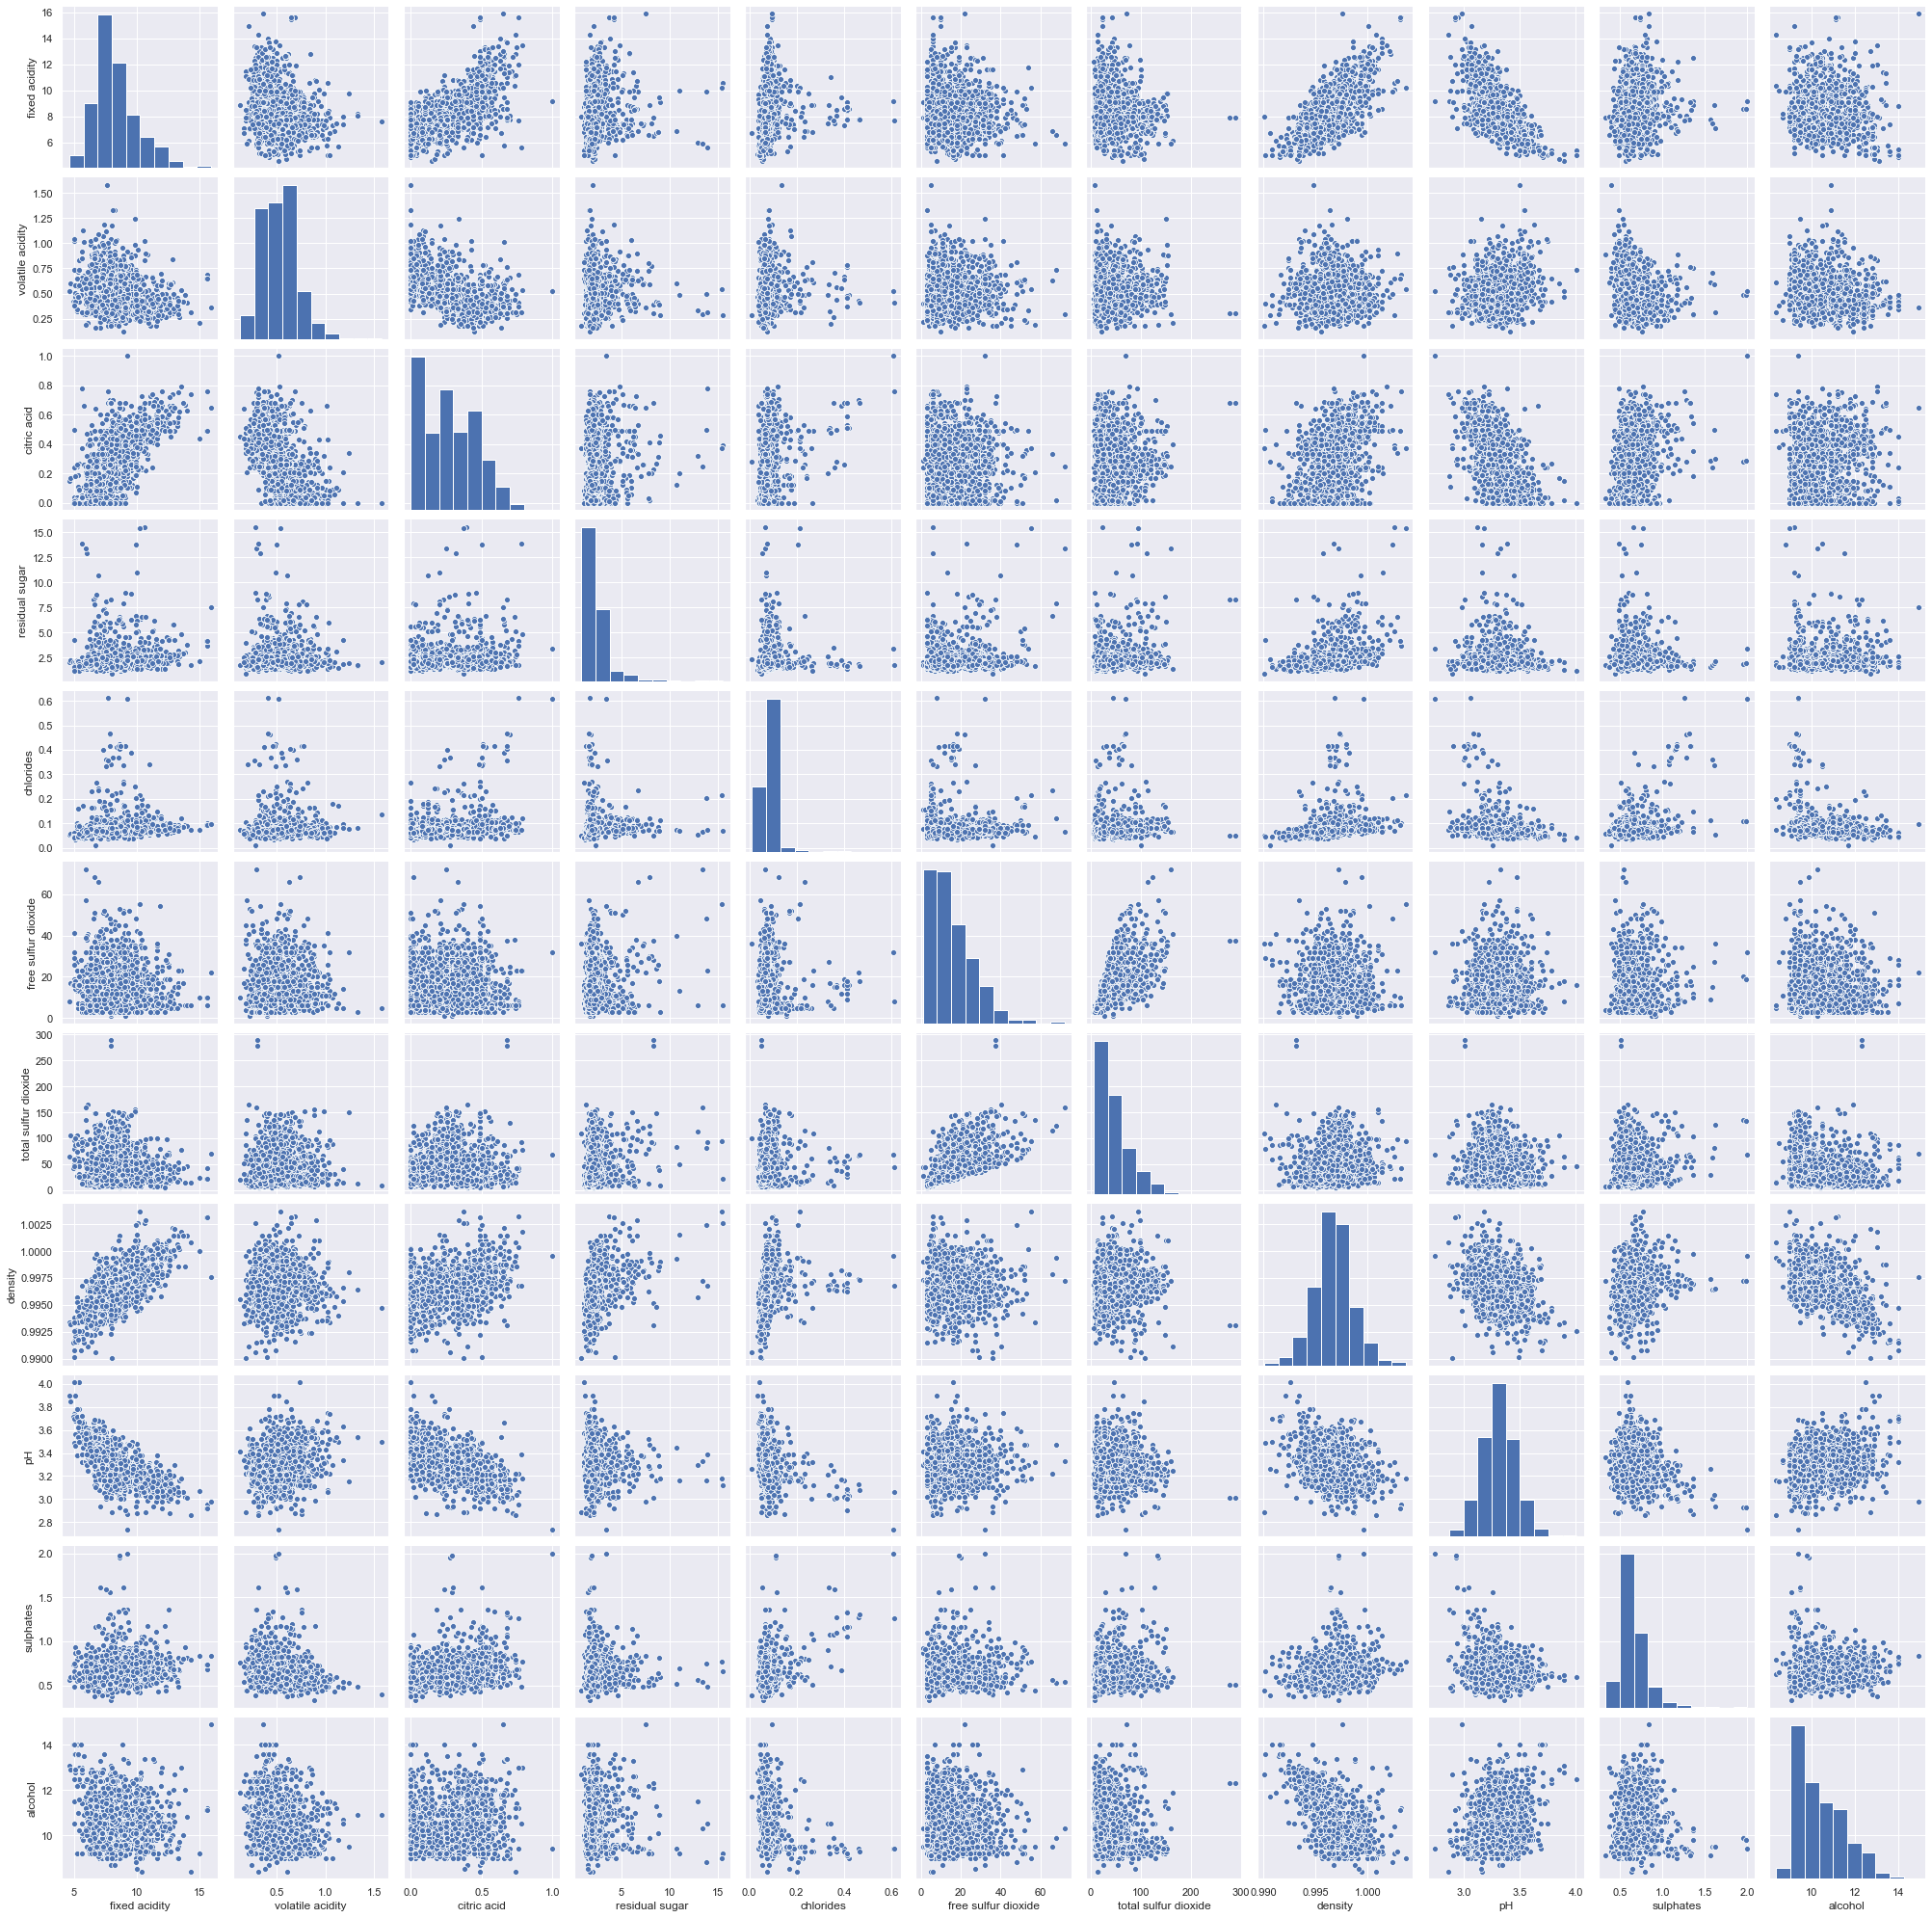

In [11]:
sns.pairplot(data=red_wines.drop('quality', axis=1))

As can be seen from the pairplot above, the distributions of the 'density', 'pH' seem like normally distributed. We may include 'fixed density' into this category as well. However the distributions of the other features do not follow a normal distribution. Different transformations can be applied to make these distributions approximately Gaussian and this may help in linear models but this will be left as a future work.

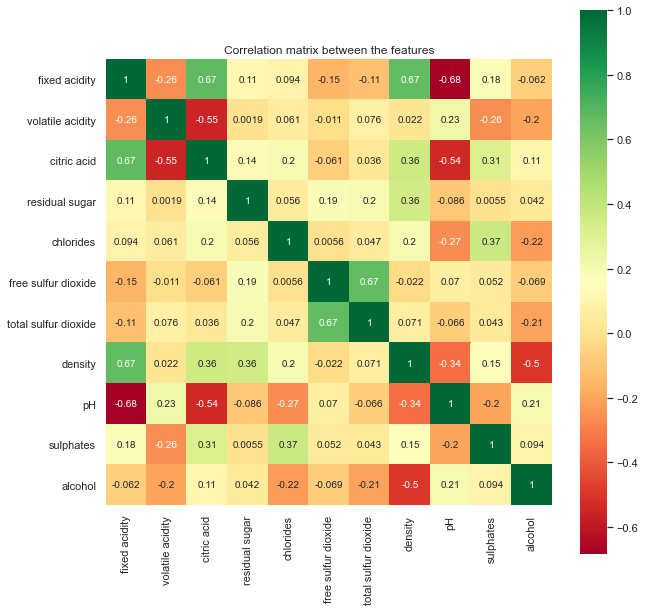

In [12]:
correlation_matrix = red_wines.drop('quality', axis=1).corr()
plt.figure(figsize=(10,10))
ax = sns.heatmap(correlation_matrix, vmax=1, square=True, annot=True, cmap='RdYlGn')
plt.title('Correlation matrix between the features')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

As can be observed from both the pairplot and correlation matrix above, fixed acidity is postively correlated with citric acid and density. Also fixed acidity is negatively correlated with pH. There are other positive and negative correlations that can be observed in the data like the positive correlation between the free sulfur dioxide and total sulfur dioxide and the negative correlation between the citric acid and volatile acidicity.  

In terms of making correct predictions, these correlations will not affect the results. However, if the coefficients assigned to these features should be studied to see which features are important, including or not including highly correlated features will make a big impact on the cofficient values. 

### Training

Let's train a logistic regression model using the one vs. rest approach. This model trains a binary classifier for each wine quality. All the features are used for training to obtain the initial results. 

In order to report the generalization error %15 percent of the dataset will be split as test set. And since there is not much data, stratified cross validation will be used for hyperparameter selection. In the end the best model with chosen hyperparameters will be trained on the whole training set. GridSearch estimator does this automatically. 

In [13]:
y = red_wines.quality
X = red_wines.drop('quality', axis=1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=seed)

In [15]:
print('Training data consists of %d instances\nTest data consists of %d instances' %(len(y_train), len(y_test)))

Training data consists of 1359 instances
Test data consists of 240 instances


In [16]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed) 

Need to use OneVsRestClassifier to be able to use the scoring functions like AUC and average precision. Macro averaging is done to comapare the scores for the multi-class calssification. 

In [17]:
y_train_mul = preprocessing.label_binarize(y_train, classes=['poor', 'mediocre', 'good'])
y_test_mul = preprocessing.label_binarize(y_test, classes=['poor', 'mediocre', 'good'])

In [18]:
def customStratifiedCV(X, y):
    y_transformed = []
    for label in y:
        if all(label==[1, 0, 0]):
            y_transformed.append('poor')
        elif all(label==[0, 1, 0]):
            y_transformed.append('mediocre')
        else:
            y_transformed.append('good')  
            
    for train, test in cv.split(X, y_transformed):
        yield train, test  

In [19]:
f1_scorer = make_scorer(f1_score, average='macro')
#roc_scorer = make_scorer(roc_auc_score, average='macro', needs_proba=True)
#average_scorer = make_scorer(average_precision_score, average='macro', needs_proba=True)
scoring = {'accuracy': 'accuracy', 'f1': f1_scorer,'roc_auc': 'roc_auc', 'average_precision': 'average_precision'}

#### Logistic Regression

In [20]:
# L2 regularization is used (L1 can be tried as well)
C = np.logspace(-3, 3, 50) 
weights = [None, 'balanced']

paramLR = {'OVR__estimator__C': C, 'OVR__estimator__class_weight': weights}
custom_cv =  customStratifiedCV(X_train, y_train_mul)

scaler = StandardScaler() # may not affect the result too much for logistic regression but can make a huge 
                          # difference for learning algorithms like SVMs

clf_LR = OneVsRestClassifier(LogisticRegression(max_iter=1000))

pipeLR = Pipeline(steps=[('SC', scaler), ('OVR', clf_LR)])

# By changing the scoring function to F1 or AUC (Area Under Curve), different metrics can be optimized
gsclfLOVR = GridSearchCV(estimator=pipeLR, param_grid=paramLR, cv=custom_cv, 
                         scoring=scoring, refit='accuracy', return_train_score=True, n_jobs=-1)

start = time.time()
gsclfLOVR.fit(X_train, y_train_mul)
end = time.time()

In [21]:
print(gsclfLOVR.best_params_)
index = gsclfLOVR.cv_results_['mean_test_accuracy'].argmax()
print('Time needed for training: {:.2f} minutes'.format((end - start)/60))
print('Accuracy on training data: %.2f' %gsclfLOVR.cv_results_['mean_train_accuracy'][index]) 
print('Accuracy on validation data: %.2f' %gsclfLOVR.best_score_) 

{'OVR__estimator__C': 0.022229964825261943, 'OVR__estimator__class_weight': None}
Time needed for training: 0.30 minutes
Accuracy on training data: 0.83
Accuracy on validation data: 0.83


In [22]:
print('AUC returned on the validation data for the parameters that optimize accuracy is %.2f' 
      %gsclfLOVR.cv_results_['mean_test_roc_auc'][index])
print('F1 score returned on the validation data for the parameters that optimize accuracy is %.2f' 
      %gsclfLOVR.cv_results_['mean_test_f1'][index])
print('Average precision returned on the validation data for the parameters that optimize accuracy is %.2f' 
      %gsclfLOVR.cv_results_['mean_test_average_precision'][index])

AUC returned on the validation data for the parameters that optimize accuracy is 0.81
F1 score returned on the validation data for the parameters that optimize accuracy is 0.41
Average precision returned on the validation data for the parameters that optimize accuracy is 0.59


In [23]:
custom_cv =  customStratifiedCV(X_train, y_train_mul)
results = cross_validate(DummyClassifier(strategy='most_frequent'), X_train, y_train_mul, return_train_score=True, cv=custom_cv, scoring=['accuracy', 'roc_auc'])

In [24]:
print('Training accuracy of dummy classifier: %.2f' %results['train_accuracy'].mean())
print('Validation accuracy of dummy classifier: %.2f' %results['test_accuracy'].mean())
print('Validation AUC of dummy classifier: %.2f' %results['test_roc_auc'].mean())

Training accuracy of dummy classifier: 0.82
Validation accuracy of dummy classifier: 0.82
Validation AUC of dummy classifier: 0.50


Our logisitc regression classiffier does not do better than a dummy classifier that predicts everything as 'medicore' - the most frequent label in the dataset in terms of accuracy. Accuracy may not be the best metric to look into when working on inbalanced data set and this data set is highly inbalanced.  

In [25]:
print('The ratio of "mediocre" to other labels ("poor" and "good") in the data set is %.2f' 
      %(pd.value_counts(red_wines.quality)['mediocre']/(pd.value_counts(red_wines.quality)['poor'] + 
                                                      pd.value_counts(red_wines.quality)['good'])))

The ratio of "mediocre" to other labels ("poor" and "good") in the data set is 4.71


In [26]:
print(classification_report(y_test_mul, gsclfLOVR.predict(X_test), zero_division=0, target_names=['poor', 'mediocre', 'good']))

              precision    recall  f1-score   support

        poor       0.00      0.00      0.00         9
    mediocre       0.83      0.99      0.90       198
        good       0.50      0.06      0.11        33

   micro avg       0.82      0.82      0.82       240
   macro avg       0.44      0.35      0.34       240
weighted avg       0.75      0.82      0.76       240
 samples avg       0.82      0.82      0.82       240



As can seen above from the test set, the classifier does not classify anything as 'poor' and the precision, recall scores for the label 'good' is not very good as well. This classifier is not a very useful classifier. 

Other metrics like AUC (Area Under Curve), precision, recall and F1 score can be studied to make comparisons. Weighting the data inversely proportional to labels can be another aspect to look into for imbalanced datsets. These will be studied as below. 

In [27]:
# L2 regularization is used (L1 can be tried as well)
C = np.logspace(-3, 3, 50) 
weights = [None, 'balanced']

paramLR = {'OVR__estimator__C': C, 'OVR__estimator__class_weight': weights}

custom_cv =  customStratifiedCV(X_train, y_train_mul)

scaler = StandardScaler() # may not affect the result too much for logistic regression but can make a huge 
                          # difference for learning algorithms like SVMs

clf_LR = OneVsRestClassifier(LogisticRegression(max_iter=1000))

pipeLR = Pipeline(steps=[('SC', scaler), ('OVR', clf_LR)])

# By changing the scoring function to F1 or AUC (Area Under Curve), different metrics can be optimized
gsclfLOVRAUC = GridSearchCV(estimator=pipeLR, param_grid=paramLR, cv=custom_cv, 
                         scoring=scoring, refit='roc_auc', return_train_score=True)

start = time.time()
gsclfLOVRAUC.fit(X_train, y_train_mul)
end = time.time()

In [28]:
print(gsclfLOVRAUC.best_params_)
index = gsclfLOVRAUC.cv_results_['mean_test_roc_auc'].argmax()
print('Time needed for training: {:.2f} minutes'.format((end - start)/60))
print('AUC on training data: %.2f' %gsclfLOVRAUC.cv_results_['mean_train_roc_auc'][index]) 
print('AUC on validation data: %.2f' %gsclfLOVRAUC.best_score_)

{'OVR__estimator__C': 0.029470517025518096, 'OVR__estimator__class_weight': None}
Time needed for training: 0.53 minutes
AUC on training data: 0.83
AUC on validation data: 0.81


In [29]:
print('Accuracy returned on the validation data for the parameters that optimize AUC is %.2f' 
      %gsclfLOVRAUC.cv_results_['mean_test_accuracy'][index])
print('F1 score returned on the validation data for the parameters that optimize AUC is %.2f' 
      %gsclfLOVRAUC.cv_results_['mean_test_f1'][index])
print('Average precision returned on the validation data for the parameters that optimize AUC is %.2f' 
      %gsclfLOVRAUC.cv_results_['mean_test_average_precision'][index])

Accuracy returned on the validation data for the parameters that optimize AUC is 0.83
F1 score returned on the validation data for the parameters that optimize AUC is 0.42
Average precision returned on the validation data for the parameters that optimize AUC is 0.59


When AUC is optimized, the results do not change much at all with logistic regression. The problem with logistic regression is underfitting. Let's try a some more sophisticated approaches like SVM with a Gaussian kernel and multilayer perceptrons. 

#### SVM

In [30]:
C = np.logspace(-3, 3, 20)
gamma = np.logspace(-3, 3, 20)
weights = [None, 'balanced']

svc = OneVsRestClassifier(SVC(kernel='rbf'))

scaler = StandardScaler() # Normalization is very important for SVMs

pipeSVM = Pipeline(steps=[('SC', scaler), ('OVR', svc)])

paramSVM = {'OVR__estimator__C': C, 'OVR__estimator__gamma': gamma, 'OVR__estimator__class_weight': weights}
custom_cv =  customStratifiedCV(X_train, y_train_mul)

gsclfSVM = GridSearchCV(estimator=pipeSVM, param_grid=paramSVM, cv=custom_cv, 
                        scoring=scoring, refit='roc_auc', return_train_score=True, n_jobs=-1)

start = time.time()
gsclfSVM.fit(X_train, y_train_mul)
end = time.time()

In [31]:
print(gsclfSVM.best_params_)
index = gsclfSVM.cv_results_['mean_test_roc_auc'].argmax()
print('Time needed for training: {:.2f} minutes'.format((end - start)/60))
print('AUC on training data: %.2f' %gsclfSVM.cv_results_['mean_train_roc_auc'][index]) 
print('AUC on validation data: %.2f' %gsclfSVM.best_score_)

{'OVR__estimator__C': 0.6951927961775606, 'OVR__estimator__class_weight': None, 'OVR__estimator__gamma': 1.438449888287663}
Time needed for training: 8.34 minutes
AUC on training data: 1.00
AUC on validation data: 0.84


In [32]:
print('Accuracy returned on the validation data for the parameters that optimize AUC is %.2f' 
      %gsclfSVM.cv_results_['mean_test_accuracy'][index])
print('F1 score returned on the validation data for the parameters that optimize AUC is %.2f' 
      %gsclfSVM.cv_results_['mean_test_f1'][index])
print('Average precision returned on the validation data for the parameters that optimize AUC is %.2f' 
      %gsclfSVM.cv_results_['mean_test_average_precision'][index])

Accuracy returned on the validation data for the parameters that optimize AUC is 0.84
F1 score returned on the validation data for the parameters that optimize AUC is 0.37
Average precision returned on the validation data for the parameters that optimize AUC is 0.60


The AUC score on the training data is high but it is lower on the validation data. The problem is overfitting here. 

#### Multi Layer Preceotron (MLP)

In [33]:
hidden_layers = [(100,), (200,), (150, 150)]
alphas = [0.001, 0.01, 0.1, 1]

mlp = MLPClassifier(solver='adam', max_iter=1000, random_state=seed)

scaler = StandardScaler() 

pipeMLP = Pipeline(steps=[('SC', scaler), ('MLP', mlp)])

paramMLP = {'MLP__alpha': alphas, 'MLP__hidden_layer_sizes': hidden_layers}
custom_cv =  customStratifiedCV(X_train, y_train_mul)

gsclfMLP = GridSearchCV(estimator=pipeMLP, param_grid=paramMLP, cv=custom_cv, 
                        scoring=scoring, refit='roc_auc', return_train_score=True, n_jobs=-1)

start = time.time()
gsclfMLP.fit(X_train, y_train_mul)
end = time.time()

In [34]:
print(gsclfMLP.best_params_)
index = gsclfMLP.cv_results_['mean_test_roc_auc'].argmax()
print('Time needed for training: {:.2f} minutes'.format((end - start)/60))
print('AUC on training data: %.2f' %gsclfMLP.cv_results_['mean_train_roc_auc'][index]) 
print('AUC on validation data: %.2f' %gsclfMLP.best_score_)

{'MLP__alpha': 1, 'MLP__hidden_layer_sizes': (200,)}
Time needed for training: 2.27 minutes
AUC on training data: 0.90
AUC on validation data: 0.82


In [35]:
print('Accuracy returned on the validation data for the parameters that optimize AUC is %.2f' 
      %gsclfMLP.cv_results_['mean_test_accuracy'][index])
print('F1 score returned on the validation data for the parameters that optimize AUC is %.2f' 
      %gsclfMLP.cv_results_['mean_test_f1'][index])
print('Average precision returned on the validation data for the parameters that optimize AUC is %.2f' 
      %gsclfMLP.cv_results_['mean_test_average_precision'][index])

Accuracy returned on the validation data for the parameters that optimize AUC is 0.83
F1 score returned on the validation data for the parameters that optimize AUC is 0.48
Average precision returned on the validation data for the parameters that optimize AUC is 0.59


#### Random Forest

In [36]:
max_depth = [40, 100, 200, None]
n_estimators = [1500] # For random forests, more trees are always better or at least do not hurt the performance
class_weight = ['balanced', None]

custom_cv =  customStratifiedCV(X_train, y_train_mul)

forest = OneVsRestClassifier(RandomForestClassifier(n_estimators= 1500, random_state=seed))

paramRF = {'estimator__max_depth': max_depth, 'estimator__class_weight': class_weight}

gsclfRF = GridSearchCV(estimator=forest, param_grid=paramRF, cv=custom_cv, 
                       scoring=scoring, refit='roc_auc', return_train_score=True, n_jobs=-1)

start = time.time()
gsclfRF.fit(X_train, y_train_mul)
end = time.time()

In [37]:
print(gsclfRF.best_params_)
index = gsclfRF.cv_results_['mean_test_roc_auc'].argmax()
print('Time needed for training: {:.2f} minutes'.format((end - start)/60))
print('AUC on training data: %.2f' %gsclfRF.cv_results_['mean_train_roc_auc'][index]) 
print('AUC on validation data: %.2f' %gsclfRF.best_score_)

{'estimator__class_weight': None, 'estimator__max_depth': 40}
Time needed for training: 3.88 minutes
AUC on training data: 1.00
AUC on validation data: 0.87


In [38]:
print('Accuracy returned on the validation data for the parameters that optimize AUC is %.2f' 
      %gsclfRF.cv_results_['mean_test_accuracy'][index])
print('F1 score returned on the validation data for the parameters that optimize AUC is %.2f' 
      %gsclfRF.cv_results_['mean_test_f1'][index])
print('Average precision returned on the validation data for the parameters that optimize AUC is %.2f' 
      %gsclfRF.cv_results_['mean_test_average_precision'][index])

Accuracy returned on the validation data for the parameters that optimize AUC is 0.86
F1 score returned on the validation data for the parameters that optimize AUC is 0.52
Average precision returned on the validation data for the parameters that optimize AUC is 0.66


## Results

In [39]:
repstring = """
<center><b>Evaluation of Different Machine Learning Models on the Validation Data</b>
<table>
<th>Model</th>
<th>Accuracy</th>
<th>F1 Score</th>
<th>Area Under Curve</th>
<th>Average Precision</th>"""

rowtemplate = """<tr>
    <td>{}</td>
    <td>{:.2f}</td>
    <td>{:.2f}</td>
    <td>{:.2f}</td>
    <td>{:.2f}</td>
</tr>"""

models = ['Logistic Regression', 'SVM', 'Multi-Layer Perceptron', 'Random Forest']

data = [[0.83, 0.42, 0.81, 0.59], [0.84, 0.37, 0.84, 0.60], [0.83, 0.45, 0.82, 0.59], [0.86, 0.52, 0.86, 0.66]]

for i, model in enumerate(models):
    dat = data[i]        
    newrow = rowtemplate.format(model, dat[0], dat[1], dat[2], dat[3])
    repstring += newrow

repstring += "\n</table></center>"

In [40]:
display(HTML(repstring))

Logistic Regression,0.83,0.42,0.81,0.59
SVM,0.84,0.37,0.84,0.60
Multi-Layer Perceptron,0.83,0.45,0.82,0.59
Random Forest,0.86,0.52,0.86,0.66


Since Random Forest gives the best results in terms of AUC on the validation data, let's choose Random Forest as our model and report the generalization error using the test data. 

In [41]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, scoring='roc_auc',
                        n_jobs=1, train_sizes=np.linspace(0.1, 1.0, 50)):
    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, '-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, '-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.grid("on")
    return plt

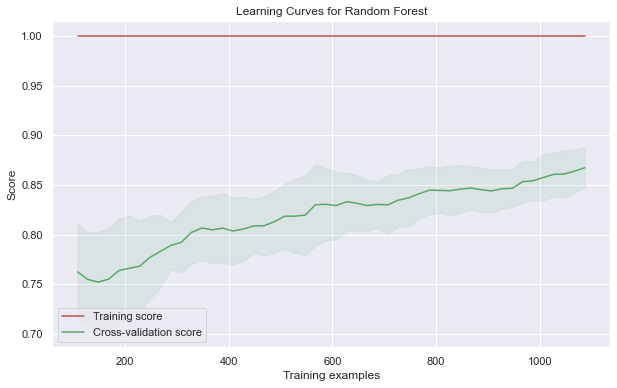

In [42]:
title = "Learning Curves for Random Forest"
custom_cv =  customStratifiedCV(X_train, y_train_mul)

plot_learning_curve(gsclfRF.best_estimator_, title, X_train, y_train_mul, cv=custom_cv, n_jobs=-1)
plt.show()

In [43]:
print(classification_report(y_test_mul, gsclfRF.predict(X_test), zero_division=0, target_names=['poor', 'mediocre', 'good']))

              precision    recall  f1-score   support

        poor       0.00      0.00      0.00         9
    mediocre       0.89      0.96      0.92       198
        good       0.73      0.48      0.58        33

   micro avg       0.87      0.86      0.87       240
   macro avg       0.54      0.48      0.50       240
weighted avg       0.83      0.86      0.84       240
 samples avg       0.86      0.86      0.86       240



In [44]:
print('Accuracy on the test data is %.2f' %accuracy_score(y_test_mul, gsclfRF.predict(X_test)))

Accuracy on the test data is 0.86


In [ ]:
res = []
for prob in gsclfRF.predict_proba(X_test):

In [58]:
print('AUC on the test data is %.2f' %roc_auc_score(y_test_mul, gsclfRF.predict_proba(X_test)))

AUC on the test data is 0.85


In [53]:
test_predictions = []
for pred in gsclfRF.predict(X_test):
    if all(pred == [1, 0, 0]):
        test_predictions.append('poor')
    elif all(pred == [0, 1, 0]):
        test_predictions.append('mediocre')
    else:
        test_predictions.append('good')

In [54]:
confusion_matrix(y_test, test_predictions, ['poor', 'mediocre', 'good'])

/Users/onur.tasasiz/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=['poor', 'mediocre', 'good'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


array([[  0,   8,   1],
       [  0, 191,   7],
       [  0,  15,  18]])

In [55]:
def draw_cm(actual, predicted, labels):
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=labels, yticklabels=labels, 
                cmap=ListedColormap(['white']), cbar=False, annot_kws={"fontsize":15})
    plt.ylabel('ACTUAL', fontsize=13)
    plt.xlabel('PREDICTED', fontsize=13)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.show()

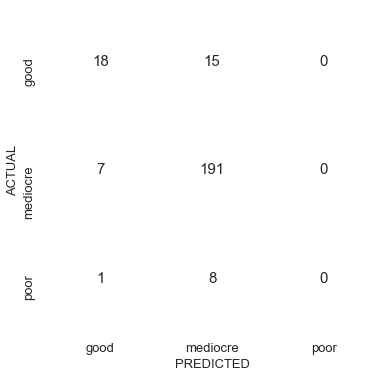

In [56]:
draw_cm(y_test, test_predictions, ['good', 'mediocre', 'poor'])

These are the generalization scores - the scores we expect on unseen data. 

In [57]:
DC = DummyClassifier(strategy='most_frequent')
DC.fit(X_train, y_train)
roc_auc_score(y_test_mul, DC.predict_proba(X_test))

0.5

Random Forest algorithm outperforms the dummy classifier that predicts everything as 'mediocre' in terms of AUC. However, as can be seen from the classification report, it does not predict any wine as poor.

As can be seen from the learning curve, the problem is definitely overfitting. As the available training data increases the AUC on validation data gets closer to the AUC on training data. More data can help improving the results. Especially gathering more that on 'poor' and 'good' wines can be useful for the algorithm to learn more about these wines. 